In [10]:
from SES_setup import *
import time
from heatmap_setup import calculate_steadystate, heat_map_calculator


dirname = 'SES_heatmap_excvN'

In [6]:
method = 'eigen'
#method = 'power'
#x_values=[6][::-1] # N
#x_values=[5,6,7,8,9,10,11][::-1] # N
x_values=[3,4,5,6,7][::-1] # N

w_2 = 8000.
alpha = 50./pi

pap = alpha_to_pialpha_prop(alpha, w_2)
wc = 100.
w_0 = 200.
Gamma = (w_0**2)/wc
PARAMS = PARAMS_setup(bias=100., w_2=8000., V = 100., pialpha_prop=pap,
                                T_EM=6000., T_ph =300.,
                                alpha_EM=0.1, shift=True,
                                num_cpus=3, N=3, Gamma=Gamma, w_0=w_0,
                                silent=True, exc_diff=0)
exc = PARAMS['exc']

 # N
#y_values=[5,4,3,2,1,0] # exc
y_values=[3,2, 1] # exc_diff (exc = 2n-exc_diff)
"""try:
    if 'iterative' in method:
        print("Using fill-factor of {}".format(ff))
"""
ss_array, info_array= heat_map_calculator(PARAMS,
                        x_axis_parameters=['N_1', 'N_2'],
                        y_axis_parameters=['exc_diff'],
                        x_values=x_values,
                        y_values=y_values,
                        dir_name='SES_heatmap_excvN',
                        fill_factor=None, save_data=True, 
                        persistent=False, method=method, threshold=1e-7)

N_1 = 7, N_2 = 7, exc= 11
Steady state took 377.875 seconds
Build time: 41.631 	 | 	 Solution time: 377.875
N_1 = 6, N_2 = 6, exc= 9
Steady state took 56.886 seconds
Build time: 19.008 	 | 	 Solution time: 56.886
N_1 = 5, N_2 = 5, exc= 7
Steady state took 9.179 seconds
Build time: 7.498 	 | 	 Solution time: 9.179
N_1 = 4, N_2 = 4, exc= 5
Steady state took 0.584 seconds
Build time: 3.196 	 | 	 Solution time: 0.584
N_1 = 3, N_2 = 3, exc= 3
Steady state took 0.102 seconds
Build time: 1.061 	 | 	 Solution time: 0.102
N_1 = 7, N_2 = 7, exc= 12
Steady state took 381.490 seconds
Build time: 42.032 	 | 	 Solution time: 381.490
N_1 = 6, N_2 = 6, exc= 10
Steady state took 61.151 seconds
Build time: 18.216 	 | 	 Solution time: 61.151
N_1 = 5, N_2 = 5, exc= 8
Steady state took 12.858 seconds
Build time: 8.237 	 | 	 Solution time: 12.858
N_1 = 4, N_2 = 4, exc= 6
Steady state took 1.029 seconds
Build time: 3.218 	 | 	 Solution time: 1.029
N_1 = 3, N_2 = 3, exc= 4
Steady state took 0.102 seconds
Buil

In [13]:
import matplotlib.pyplot as plt

def steadystate_observable(ss_array, PARAMS, observable):
    try:
        size = (len(PARAMS['y_values']), len(PARAMS['x_values']))
    except KeyError:
        size = (1,1)
    # deal with the case where N is being changed as an x value
    if 'N_1' in PARAMS['x_axis_parameters']:
        data_array = np.zeros(size)         # Collect data
        N_values = PARAMS['x_values']
        # NEw observable operator for each N value
        for i, N in enumerate(N_values):
            PARAMS.update({'N_1' : N, 'N_2' : N})
            exc = N+PARAMS['exc_diff']
            # Leave it so exc can be fixed or a y_parameter
            if 'exc' in PARAMS['x_axis_parameters']:
                PARAMS.update({'exc': exc})
            _obs_op = make_expectation_operators(PARAMS)[observable]
            for j, y in enumerate(PARAMS['y_values']):
                # the case where exc is on the y axis
                if 'exc_diff' in PARAMS['y_axis_parameters']:
                    PARAMS.update({'exc': N+y})
                    _obs_op = make_expectation_operators(PARAMS)[observable]
                try:
                    print ss_array[j][i].shape, _obs_op.shape
                    data_array[j][i] = (qt.Qobj(ss_array[j][i])*_obs_op).tr().real
                except AttributeError:
                    data_array[j][i] = np.nan
        return data_array
    else:
        # Much simpler if N isn't on the x-axis
        obs_op = make_expectation_operators(PARAMS)[observable]
        f = lambda x: (qt.Qobj(x)*obs_op).tr()
        ss_array = np.reshape(ss_array, (1, size[0]*size[1]))[0]

        data_array = map(f, ss_array)
        data_array = np.array(data_array).reshape(size).real
        return data_array


def heatmap_plotter(num, plot_SD=True, dir_name="heatmap", 
                     print_params=False, observable='sigma_x', 
                    reverse_x=True):
    
    directory = 'DATA/'+dir_name+'_'+str(num)
    ss_array = load_obj(directory+'/ss_array')
    PARAMS = load_obj(directory+'/PARAMS')
    info_array = load_obj(directory+'/info_array') # reverse ordering -> lower_N-higher_N
    info = info_array[0][0]
    
    try:
        # To catch an old bug where these were in "info" not in PARAMS
        keys = ['x_values', 'y_values', 'y_axis_parameters', 'x_axis_parameters']
        PARAMS.update(dict((key, info[key]) for key in keys))
    except Exception as err:
        print "new style"
    if plot_SD:
        plot_UD_SD(PARAMS["Gamma_1"], PARAMS["alpha_1"], PARAMS["w0_1"], eps=2000.)
    
    ss_array = steadystate_observable(ss_array, PARAMS, observable)

    
    f, axes = plt.subplots(1,1, figsize=(13,6))
    for i, y_val in enumerate(PARAMS['y_values']):
        x_values = PARAMS['x_values']
        if reverse_x:
            x_values = x_values[::-1]
        axes.plot(x_values, ss_array[i], 
                  label=str(PARAMS['y_axis_parameters'])+"="+str(y_val))
    
    print_PARAMS(PARAMS)
    
    plt.xlabel(', '.join(PARAMS['x_axis_parameters']))
    plt.ylabel("Steadystate "+observable)
    #plt.ylabel(', '.join(info['y_axis_parameters']))
    plt.legend()
    plt.grid()
    plot_filename = 'PLOTS/'+dir_name+'_'+str(num)+'.pdf'
    plt.savefig(plot_filename)
    print "saved at {}".format(plot_filename)
    plt.show()

new style


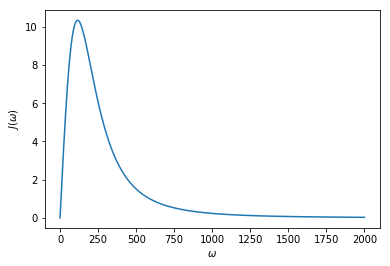

(144, 144) (138, 138)


ValueError: dimension mismatch

In [12]:
heatmap_plotter(1, plot_SD=True, dir_name=dirname, 
                     print_params=False, observable='sigma_x', 
                    reverse_x=True)